# Dependencies and data

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error as mse

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor

from joblib import dump, load, Parallel, delayed

In [2]:
metadata = pd.read_csv('../data/metadata.csv')
sub_format = pd.read_csv('../data/submission_format.csv')
train_labels = pd.read_csv('../data/train_labels.csv')

In [274]:
metadata.date = pd.to_datetime(metadata.date)
metadata['year'] = metadata.date.dt.year
metadata['month'] = metadata.date.dt.month
metadata['week'] = metadata.date.dt.isocalendar().week

seasons = {
    1: 1,
    2: 1,
    3: 2,
    4: 2,
    5: 2,
    6: 3,
    7: 3,
    8: 3,
    9: 4,
    10: 4,
    11: 4,
    12: 1
}

reg_sev_map = {
    'midwest': 2,
    'northeast': 2,
    'south' : 2,
    'west' : 4
}

reg_map = {
    'south' : 0,
    'northeast' : 1,
    'west' : 2,
    'midwest' : 3
}

metadata['season'] = metadata.month.map(seasons)

region = pd.concat((train_labels, sub_format[['region', 'uid']]), axis=0)

all_data = pd.merge(metadata, region, on='uid', how='left')
data = all_data.copy(deep=True)
data.sort_values(by='date', inplace=True)
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
4387,evep,44.847993,-93.476318,2013-01-04,train,2013,1,1,1,midwest,1.0,115.0
13644,paev,44.822478,-93.367962,2013-01-04,train,2013,1,1,1,midwest,1.0,1884.0
5566,gdxr,44.877646,-93.557842,2013-01-04,train,2013,1,1,1,midwest,1.0,1416.0
6144,guny,44.878889,-93.490833,2013-01-04,train,2013,1,1,1,midwest,1.0,558.0
5317,fwbt,44.850500,-93.515700,2013-01-04,train,2013,1,1,1,midwest,1.0,476.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12443,nsoi,36.736800,-121.734000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
17559,thki,36.725400,-121.730000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
17452,teuu,36.772300,-121.788000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
14254,prfi,36.751800,-121.742000,2021-12-29,test,2021,12,52,1,west,NaN,NaN


# Utils

In [4]:

def analyize_matches(y_true, y_pred, plot=False):
    print("Exact matches: ", sum(y_true == y_pred) / len(y_true))
    print("Missed by 1: ", sum(abs(y_true - y_pred) == 1) / len(y_true))
    print("Missed by 2: ", sum(abs(y_true - y_pred) == 2) / len(y_true))
    print("Missed by 3: ", sum(abs(y_true - y_pred) == 3) / len(y_true))
    print("Missed by 4: ", sum(abs(y_true - y_pred) == 4) / len(y_true))
    
    stupid_vals = []
    for i in range(1, 6):
        stupid_vals.append(
            ((sum([1 for x, y in zip(y_true, y_pred) if x == i and y == i])/len(y_true))*100, (sum(y_true == i)/len(y_true))*100)
            )

    print()
    for i in range(5):
        print(f"Severity {i+1} : accuracy: {np.round(stupid_vals[i][0], 3)} % - prevalence: {np.round(stupid_vals[i][1], 3)} %")
    
    try:
        print()
        print("Classification report:")
        print(classification_report(y_true, y_pred))
    except Exception as e:
        print(e)
        print("Classification report failed")
        
    if plot:
        print()
        sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Reds')


def rmse(y_true, y_pred):
    return mse(y_true, y_pred, squared=False)

def get_data_by_date( date=None, data=None):
    return data[data.date == date]


def get_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

# Knn fts

In [5]:
def knn(row=None, train_data=None, k=1):
    """
    row : pd.Series (row from val_data)
    train_data : pd.DataFrame (all_data)
    k : int number of nearest neighbours to consider
    
    algo:
    1. Get past month data collected till the current row
    2. Get the k nearest neighbours (geodesic dist using lat, lng) from the above data
    3. Get the mean of the severity from the above rows
    4. Return the mean of the nearest neighbours severity

    """
    
    if row is None:
        print('Row None bruv!')
        return None
    
    uid = row.uid
    date = row.date
    region = row.region
    past_date = date - pd.Timedelta(days=30)
    
    past_month_data = train_data[(train_data.date < date) & (train_data.date >= past_date)]
    past_month_data.sort_values(by='date', inplace=True)
    
    # if no past data, return the mean of the region
    if len(past_month_data) == 0:
        return reg_sev_map[region]
        
    dist_matrix =pd.DataFrame(columns=['uid', 'dist'])       # 0th col for uid, 1st col for dist
    for i, past_row in enumerate(past_month_data.itertuples()):
        dist_matrix.loc[i, 'uid'] = past_row.uid
        dist_matrix.loc[i, 'dist'] = get_distance(row.latitude, row.longitude, past_row.latitude, past_row.longitude)   # returns geodesic dist in km

    # get mean of top k nearest neighbours
    n_uids = dist_matrix.sort_values(by='dist').head(k).uid.values
    nn_severity = train_data[train_data.uid.isin(n_uids)].severity.mean()
    

    if nn_severity not in range(1, 6):
        return reg_sev_map[region]

    return np.round(nn_severity)

In [6]:
def knn_wrapper(data, k=5):
    preds = []
    for row in tqdm(data.itertuples(), total=len(data)):
        severity = knn(row, train_data=data, k=15)
        preds.append(severity)
    return preds

In [7]:
# def knn_wrapper(data, k=5):
#     sev_list = Parallel(n_jobs=-1, backend='threading')([delayed(knn)(row, train_data=data, k=k) for row in data.itertuples()])
#     return sev_list

In [8]:
data = data.sort_values(by='date')
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
4387,evep,44.847993,-93.476318,2013-01-04,train,2013,1,1,1,midwest,1.0,115.0
13644,paev,44.822478,-93.367962,2013-01-04,train,2013,1,1,1,midwest,1.0,1884.0
5566,gdxr,44.877646,-93.557842,2013-01-04,train,2013,1,1,1,midwest,1.0,1416.0
6144,guny,44.878889,-93.490833,2013-01-04,train,2013,1,1,1,midwest,1.0,558.0
5317,fwbt,44.850500,-93.515700,2013-01-04,train,2013,1,1,1,midwest,1.0,476.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12443,nsoi,36.736800,-121.734000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
17559,thki,36.725400,-121.730000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
17452,teuu,36.772300,-121.788000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
14254,prfi,36.751800,-121.742000,2021-12-29,test,2021,12,52,1,west,NaN,NaN


In [9]:
# %%time

# tar_data = data
# knn15_preds = []
# for row in tqdm(tar_data.itertuples(), total=len(tar_data)):
#     severity = knn(row, train_data=tar_data, k=15)
#     knn15_preds.append(severity)

# Add fts

In [10]:
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
4387,evep,44.847993,-93.476318,2013-01-04,train,2013,1,1,1,midwest,1.0,115.0
13644,paev,44.822478,-93.367962,2013-01-04,train,2013,1,1,1,midwest,1.0,1884.0
5566,gdxr,44.877646,-93.557842,2013-01-04,train,2013,1,1,1,midwest,1.0,1416.0
6144,guny,44.878889,-93.490833,2013-01-04,train,2013,1,1,1,midwest,1.0,558.0
5317,fwbt,44.850500,-93.515700,2013-01-04,train,2013,1,1,1,midwest,1.0,476.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12443,nsoi,36.736800,-121.734000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
17559,thki,36.725400,-121.730000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
17452,teuu,36.772300,-121.788000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
14254,prfi,36.751800,-121.742000,2021-12-29,test,2021,12,52,1,west,NaN,NaN


In [277]:
train_data_ = data[data.split == 'train']
train_data_.severity.value_counts(normalize=True)

1.0    0.439449
4.0    0.207913
2.0    0.189859
3.0    0.159379
5.0    0.003400
Name: severity, dtype: float64

In [278]:
grp_by_r = data.groupby(['region']).severity.mean()
grp_by_r = grp_by_r.map(np.round)
print(grp_by_r.isna().sum())  
grp_by_r.fillna(grp_by_r.groupby('region').transform('mean'), inplace=True)
print(grp_by_r.isna().sum())

grp_by_r_preds = data[['region']].apply(lambda x: grp_by_r[x.region], axis=1)
analyize_matches(train_data_.severity.sort_index(), grp_by_r_preds.loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), grp_by_r_preds.loc[train_data_.index].sort_index())

0
0
Exact matches:  0.37116060961313013
Missed by 1:  0.5907385697538101
Missed by 2:  0.02661195779601407
Missed by 3:  0.011488862837045722
Missed by 4:  0.0

Severity 1 : accuracy: 0.0 % - prevalence: 43.945 %
Severity 2 : accuracy: 18.388 % - prevalence: 18.986 %
Severity 3 : accuracy: 0.0 % - prevalence: 15.938 %
Severity 4 : accuracy: 18.728 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.34 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      7497
         2.0       0.24      0.97      0.38      3239
         3.0       0.00      0.00      0.00      2719
         4.0       0.85      0.90      0.87      3547
         5.0       0.00      0.00      0.00        58

    accuracy                           0.37     17060
   macro avg       0.22      0.37      0.25     17060
weighted avg       0.22      0.37      0.25     17060



0.894754808017972

In [279]:
grp_by_r = data.groupby(['month']).severity.mean()
grp_by_r = grp_by_r.map(np.round)
print(grp_by_r.isna().sum())  
grp_by_r.fillna(grp_by_r.groupby('month').transform('mean'), inplace=True)
print(grp_by_r.isna().sum())

grp_by_r_preds = data[['month']].apply(lambda x: grp_by_r[x.month], axis=1)
analyize_matches(train_data_.severity.sort_index(), grp_by_r_preds.loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), grp_by_r_preds.loc[train_data_.index].sort_index())

0
0
Exact matches:  0.18856975381008206
Missed by 1:  0.6035169988276671
Missed by 2:  0.20463071512309497
Missed by 3:  0.0032825322391559202
Missed by 4:  0.0

Severity 1 : accuracy: 0.0 % - prevalence: 43.945 %
Severity 2 : accuracy: 18.312 % - prevalence: 18.986 %
Severity 3 : accuracy: 0.545 % - prevalence: 15.938 %
Severity 4 : accuracy: 0.0 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.34 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      7497
         2.0       0.20      0.96      0.33      3239
         3.0       0.07      0.03      0.05      2719
         4.0       0.00      0.00      0.00      3547
         5.0       0.00      0.00      0.00        58

    accuracy                           0.19     17060
   macro avg       0.05      0.20      0.08     17060
weighted avg       0.05      0.19      0.07     17060



1.2048164380819388

In [280]:
grp_by_r = data.groupby(['season']).severity.mean()
grp_by_r = grp_by_r.map(np.round)
print(grp_by_r.isna().sum())  
grp_by_r.fillna(grp_by_r.groupby('season').transform('mean'), inplace=True)
print(grp_by_r.isna().sum())

grp_by_r_preds = data[['season']].apply(lambda x: grp_by_r[x.season], axis=1)
analyize_matches(train_data_.severity.sort_index(), grp_by_r_preds.loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), grp_by_r_preds.loc[train_data_.index].sort_index())

0
0
Exact matches:  0.18985932004689332
Missed by 1:  0.5988276670574443
Missed by 2:  0.2079132473622509
Missed by 3:  0.003399765533411489
Missed by 4:  0.0

Severity 1 : accuracy: 0.0 % - prevalence: 43.945 %
Severity 2 : accuracy: 18.986 % - prevalence: 18.986 %
Severity 3 : accuracy: 0.0 % - prevalence: 15.938 %
Severity 4 : accuracy: 0.0 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.34 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      7497
         2.0       0.19      1.00      0.32      3239
         3.0       0.00      0.00      0.00      2719
         4.0       0.00      0.00      0.00      3547
         5.0       0.00      0.00      0.00        58

    accuracy                           0.19     17060
   macro avg       0.04      0.20      0.06     17060
weighted avg       0.04      0.19      0.06     17060



1.2087508206024726

In [281]:
grp_by_r = data.groupby(['year']).severity.mean()
grp_by_r = grp_by_r.map(np.round)
print(grp_by_r.isna().sum())  
grp_by_r.fillna(grp_by_r.groupby('year').transform('mean'), inplace=True)
print(grp_by_r.isna().sum())

grp_by_r_preds = data[['year']].apply(lambda x: grp_by_r[x.year], axis=1)
analyize_matches(train_data_.severity.sort_index(), grp_by_r_preds.loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), grp_by_r_preds.loc[train_data_.index].sort_index())

0
0
Exact matches:  0.18985932004689332
Missed by 1:  0.5988276670574443
Missed by 2:  0.2079132473622509
Missed by 3:  0.003399765533411489
Missed by 4:  0.0

Severity 1 : accuracy: 0.0 % - prevalence: 43.945 %
Severity 2 : accuracy: 18.986 % - prevalence: 18.986 %
Severity 3 : accuracy: 0.0 % - prevalence: 15.938 %
Severity 4 : accuracy: 0.0 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.34 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      7497
         2.0       0.19      1.00      0.32      3239
         3.0       0.00      0.00      0.00      2719
         4.0       0.00      0.00      0.00      3547
         5.0       0.00      0.00      0.00        58

    accuracy                           0.19     17060
   macro avg       0.04      0.20      0.06     17060
weighted avg       0.04      0.19      0.06     17060



1.2087508206024726

In [282]:
grp_by_w = data.groupby(['week']).severity.mean()
grp_by_w = grp_by_w.map(np.round)
print(grp_by_w.isna().sum())  
grp_by_w.fillna(grp_by_w.groupby('week').transform('mean'), inplace=True)
print(grp_by_w.isna().sum())

grp_by_w_preds = data[['week']].apply(lambda x: grp_by_w[x.week], axis=1)
analyize_matches(train_data_.severity.sort_index(), grp_by_w_preds.loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), grp_by_w_preds.loc[train_data_.index].sort_index())

1
1
Exact matches:  0.2026377491207503
Missed by 1:  0.6036928487690504
Missed by 2:  0.1888042203985932
Missed by 3:  0.004865181711606096
Missed by 4:  0.0

Severity 1 : accuracy: 1.002 % - prevalence: 43.945 %
Severity 2 : accuracy: 17.761 % - prevalence: 18.986 %
Severity 3 : accuracy: 0.891 % - prevalence: 15.938 %
Severity 4 : accuracy: 0.61 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.34 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.83      0.02      0.04      7497
         2.0       0.21      0.94      0.34      3239
         3.0       0.08      0.06      0.06      2719
         4.0       0.81      0.03      0.06      3547
         5.0       0.00      0.00      0.00        58

    accuracy                           0.20     17060
   macro avg       0.39      0.21      0.10     17060
weighted avg       0.59      0.20      0.11     17060



1.1843548310231518

In [283]:
exp_grp_by_rm = data.groupby(['region', 'month']).severity.expanding(1).mean()
exp_grp_by_rm = exp_grp_by_rm.map(np.round)
print(exp_grp_by_rm.isna().sum())  
exp_grp_by_rm.droplevel(0).droplevel(0)
exp_grp_by_rm.fillna(exp_grp_by_rm.groupby('region').transform('mean'), inplace=True)
print(exp_grp_by_rm.isna().sum())  
analyize_matches(train_data_.severity.sort_index(), exp_grp_by_rm.droplevel(0).droplevel(0).loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), np.round(exp_grp_by_rm.droplevel(0).droplevel(0).loc[train_data_.index].sort_index()))

72
0
Exact matches:  0.5014067995310668
Missed by 1:  0.44021101992966
Missed by 2:  0.04824150058616647
Missed by 3:  0.009730363423212192
Missed by 4:  0.00041031652989449003

Severity 1 : accuracy: 19.965 % - prevalence: 43.945 %
Severity 2 : accuracy: 12.767 % - prevalence: 18.986 %
Severity 3 : accuracy: 0.545 % - prevalence: 15.938 %
Severity 4 : accuracy: 16.864 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.34 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.72      0.45      0.56      7497
         2.0       0.26      0.67      0.37      3239
         3.0       0.18      0.03      0.06      2719
         4.0       0.86      0.81      0.84      3547
         5.0       0.00      0.00      0.00        58

    accuracy                           0.50     17060
   macro avg       0.40      0.39      0.36     17060
weighted avg       0.57      0.50      0.50     17060



0.8528278592784991

In [284]:
grp_by_rm = data.groupby(['region', 'month']).severity.mean()
grp_by_rm = grp_by_rm.map(np.round)
print(grp_by_rm.isna().sum())  
grp_by_rm.fillna(grp_by_rm.groupby('region').transform('mean'), inplace=True)
print(grp_by_rm.isna().sum())

grp_by_rm_preds = data[['region', 'month']].apply(lambda x: grp_by_rm[x.region, x.month], axis=1)
analyize_matches(train_data_.severity.sort_index(), grp_by_rm_preds.loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), grp_by_rm_preds.loc[train_data_.index].sort_index())

1
0
Exact matches:  0.4742672919109027
Missed by 1:  0.4705158264947245
Missed by 2:  0.04660023446658851
Missed by 3:  0.008382180539273153
Missed by 4:  0.00023446658851113716

Severity 1 : accuracy: 15.768 % - prevalence: 43.945 %
Severity 2 : accuracy: 13.271 % - prevalence: 18.986 %
Severity 3 : accuracy: 2.069 % - prevalence: 15.938 %
Severity 4 : accuracy: 16.319 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.34 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.73      0.36      0.48      7497
         2.0       0.25      0.70      0.37      3239
         3.0       0.29      0.13      0.18      2719
         4.0       0.86      0.78      0.82      3547
         5.0       0.00      0.00      0.00        58

    accuracy                           0.47     17060
   macro avg       0.43      0.39      0.37     17060
weighted avg       0.59      0.47      0.48     17060



0.8579672806294627

In [285]:
exp_grp_by_rmy = data.groupby(['region', 'month', 'year']).severity.expanding(1).mean()
exp_grp_by_rmy = exp_grp_by_rmy.map(np.round)
print(exp_grp_by_rmy.isna().sum())  
exp_grp_by_rmy.droplevel(0).droplevel(0)
exp_grp_by_rmy.fillna(exp_grp_by_rmy.groupby('region').transform('mean'), inplace=True)
print(exp_grp_by_rmy.isna().sum())  
analyize_matches(train_data_.severity.sort_index(), exp_grp_by_rmy.droplevel(0).droplevel(0).droplevel(0).loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), np.round(exp_grp_by_rmy.droplevel(0).droplevel(0).droplevel(0).loc[train_data_.index].sort_index()))

611
0
Exact matches:  0.5368112543962485
Missed by 1:  0.41770222743259083
Missed by 2:  0.04044548651817116
Missed by 3:  0.004865181711606096
Missed by 4:  0.00017584994138335287

Severity 1 : accuracy: 20.991 % - prevalence: 43.945 %
Severity 2 : accuracy: 13.118 % - prevalence: 18.986 %
Severity 3 : accuracy: 2.778 % - prevalence: 15.938 %
Severity 4 : accuracy: 16.758 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.035 % - prevalence: 0.34 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.77      0.48      0.59      7497
         2.0       0.28      0.69      0.40      3239
         3.0       0.39      0.17      0.24      2719
         4.0       0.90      0.81      0.85      3547
         5.0       1.00      0.10      0.19        58

    accuracy                           0.54     17060
   macro avg       0.67      0.45      0.45     17060
weighted avg       0.64      0.54      0.55     17060



0.7912549576286168

In [286]:
grp_by_rmy = data.groupby(['region', 'month', 'year']).severity.mean()
grp_by_rmy = grp_by_rmy.map(np.round)
print(grp_by_rmy.isna().sum())  
grp_by_rmy.fillna(grp_by_rmy.groupby('region').transform('mean'), inplace=True)
print(grp_by_rmy.isna().sum())

grp_by_rmy_preds = data[['region', 'month', 'year']].apply(lambda x: grp_by_rmy[x.region, x.month, x.year], axis=1)
analyize_matches(train_data_.severity.sort_index(), grp_by_rmy_preds.loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), grp_by_rmy_preds.loc[train_data_.index].sort_index())

20
0
Exact matches:  0.5093200468933177
Missed by 1:  0.4429073856975381
Missed by 2:  0.04220398593200469
Missed by 3:  0.005392731535756155
Missed by 4:  0.00017584994138335287

Severity 1 : accuracy: 18.576 % - prevalence: 43.945 %
Severity 2 : accuracy: 13.212 % - prevalence: 18.986 %
Severity 3 : accuracy: 2.532 % - prevalence: 15.938 %
Severity 4 : accuracy: 16.612 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.34 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.76      0.42      0.54      7497
         2.0       0.27      0.70      0.39      3239
         3.0       0.33      0.16      0.22      2719
         4.0       0.89      0.80      0.84      3547
         5.0       0.00      0.00      0.00        58

    accuracy                           0.51     17060
   macro avg       0.45      0.42      0.40     17060
weighted avg       0.62      0.51      0.52     17060



0.814292031343483

In [287]:
grp_by_rsy = data.groupby(['region', 'season', 'year']).severity.mean()
grp_by_rsy = grp_by_rsy.map(np.round)
print(grp_by_rsy.isna().sum())  
grp_by_rsy.fillna(grp_by_rsy.groupby('region').transform('mean'), inplace=True)
print(grp_by_rsy.isna().sum())

grp_by_rsy_preds = data[['region', 'season', 'year']].apply(lambda x: grp_by_rsy[x.region, x.season, x.year], axis=1)
analyize_matches(train_data_.severity.sort_index(), grp_by_rsy_preds.loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), grp_by_rsy_preds.loc[train_data_.index].sort_index())

5
0
Exact matches:  0.49947245017584996
Missed by 1:  0.4484759671746776
Missed by 2:  0.044372801875732705
Missed by 3:  0.007327080890973036
Missed by 4:  0.00035169988276670573

Severity 1 : accuracy: 18.453 % - prevalence: 43.945 %
Severity 2 : accuracy: 12.855 % - prevalence: 18.986 %
Severity 3 : accuracy: 1.8 % - prevalence: 15.938 %
Severity 4 : accuracy: 16.841 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.34 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.73      0.42      0.53      7497
         2.0       0.26      0.68      0.37      3239
         3.0       0.30      0.11      0.16      2719
         4.0       0.89      0.81      0.85      3547
         5.0       0.00      0.00      0.00        58

    accuracy                           0.50     17060
   macro avg       0.43      0.40      0.38     17060
weighted avg       0.60      0.50      0.51     17060



0.8351874644776662

In [288]:
grp_by_rms = data.groupby(['region', 'month', 'season']).severity.mean()
grp_by_rms = grp_by_rms.map(np.round)
print(grp_by_rms.isna().sum())  
grp_by_rms.fillna(grp_by_rms.groupby('region').transform('mean'), inplace=True)
print(grp_by_rms.isna().sum())

grp_by_rms_preds = data[['region', 'month', 'season']].apply(lambda x: grp_by_rms[x.region, x.month, x.season], axis=1)
analyize_matches(train_data_.severity.sort_index(), grp_by_rms_preds.loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), grp_by_rms_preds.loc[train_data_.index].sort_index())

1
0
Exact matches:  0.4742672919109027
Missed by 1:  0.4705158264947245
Missed by 2:  0.04660023446658851
Missed by 3:  0.008382180539273153
Missed by 4:  0.00023446658851113716

Severity 1 : accuracy: 15.768 % - prevalence: 43.945 %
Severity 2 : accuracy: 13.271 % - prevalence: 18.986 %
Severity 3 : accuracy: 2.069 % - prevalence: 15.938 %
Severity 4 : accuracy: 16.319 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.34 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.73      0.36      0.48      7497
         2.0       0.25      0.70      0.37      3239
         3.0       0.29      0.13      0.18      2719
         4.0       0.86      0.78      0.82      3547
         5.0       0.00      0.00      0.00        58

    accuracy                           0.47     17060
   macro avg       0.43      0.39      0.37     17060
weighted avg       0.59      0.47      0.48     17060



0.8579672806294627

In [289]:
grp_by_smr = data.groupby(['season', 'month', 'region']).severity.mean()
grp_by_smr = grp_by_smr.map(np.round)
print(grp_by_smr.isna().sum())  
grp_by_smr.fillna(grp_by_smr.groupby('season').transform('mean'), inplace=True)
print(grp_by_smr.isna().sum())

grp_by_smr_preds = data[['season', 'month', 'region']].apply(lambda x: grp_by_smr[x.season, x.month, x.region], axis=1)
analyize_matches(train_data_.severity.sort_index(), grp_by_smr_preds.loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), grp_by_smr_preds.loc[train_data_.index].sort_index())

1
0
Exact matches:  0.4742672919109027
Missed by 1:  0.4705158264947245
Missed by 2:  0.04660023446658851
Missed by 3:  0.008382180539273153
Missed by 4:  0.00023446658851113716

Severity 1 : accuracy: 15.768 % - prevalence: 43.945 %
Severity 2 : accuracy: 13.271 % - prevalence: 18.986 %
Severity 3 : accuracy: 2.069 % - prevalence: 15.938 %
Severity 4 : accuracy: 16.319 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.34 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.73      0.36      0.48      7497
         2.0       0.25      0.70      0.37      3239
         3.0       0.29      0.13      0.18      2719
         4.0       0.86      0.78      0.82      3547
         5.0       0.00      0.00      0.00        58

    accuracy                           0.47     17060
   macro avg       0.43      0.39      0.37     17060
weighted avg       0.59      0.47      0.48     17060



0.8579672806294627

In [290]:
grp_by_msy = data.groupby(['month', 'season', 'year']).severity.mean()
grp_by_msy = grp_by_msy.map(np.round)
print(grp_by_msy.isna().sum())  
grp_by_msy.fillna(grp_by_msy.groupby('month').transform('mean'), inplace=True)
print(grp_by_msy.isna().sum())

grp_by_msy_preds = data[['month', 'season', 'year']].apply(lambda x: grp_by_msy[x.month, x.season, x.year], axis=1)
analyize_matches(train_data_.severity.sort_index(), grp_by_msy_preds.loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), grp_by_msy_preds.loc[train_data_.index].sort_index())

0
0
Exact matches:  0.19536928487690505
Missed by 1:  0.6080304806565064
Missed by 2:  0.19343493552168817
Missed by 3:  0.0031652989449003515
Missed by 4:  0.0

Severity 1 : accuracy: 0.0 % - prevalence: 43.945 %
Severity 2 : accuracy: 18.382 % - prevalence: 18.986 %
Severity 3 : accuracy: 0.604 % - prevalence: 15.938 %
Severity 4 : accuracy: 0.551 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.34 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      7497
         2.0       0.20      0.97      0.33      3239
         3.0       0.09      0.04      0.05      2719
         4.0       0.91      0.03      0.05      3547
         5.0       0.00      0.00      0.00        58

    accuracy                           0.20     17060
   macro avg       0.24      0.21      0.09     17060
weighted avg       0.24      0.20      0.08     17060



1.1875428048063625

In [291]:
# rolling severity average
rolling_severity = data.severity.rolling(3).mean()
rolling_severity = rolling_severity.map(np.round)
rolling_severity.fillna(rolling_severity.mean(), inplace=True)
print(rolling_severity.isna().sum())
analyize_matches(train_data_.severity.sort_index(), rolling_severity.loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), rolling_severity.loc[train_data_.index].sort_index())

0
Exact matches:  0.3873974208675264
Missed by 1:  0.2776670574443142
Missed by 2:  0.0335873388042204
Missed by 3:  0.0004689331770222743
Missed by 4:  0.0

Severity 1 : accuracy: 19.959 % - prevalence: 43.945 %
Severity 2 : accuracy: 7.843 % - prevalence: 18.986 %
Severity 3 : accuracy: 3.476 % - prevalence: 15.938 %
Severity 4 : accuracy: 7.462 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.34 %

Classification report:
Classification metrics can't handle a mix of multiclass and continuous targets
Classification report failed


0.9522160209597399

In [292]:
# rolling severity average grouped by region

rolling_severity_by_r = data.groupby('region').severity.rolling(3).mean()
rolling_severity_by_r = rolling_severity_by_r.map(np.round)
rolling_severity_by_r.fillna(rolling_severity_by_r.groupby('region').transform('mean'), inplace=True)
rolling_severity_by_r = rolling_severity_by_r.map(np.round)
print(rolling_severity_by_r.isna().sum())
analyize_matches(train_data_.severity.sort_index(), rolling_severity_by_r.droplevel(0).loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), rolling_severity_by_r.droplevel(0).loc[train_data_.index].sort_index())

0
Exact matches:  0.5961899179366941
Missed by 1:  0.3767878077373974
Missed by 2:  0.021512309495896834
Missed by 3:  0.005509964830011723
Missed by 4:  0.0

Severity 1 : accuracy: 25.539 % - prevalence: 43.945 %
Severity 2 : accuracy: 12.585 % - prevalence: 18.986 %
Severity 3 : accuracy: 3.359 % - prevalence: 15.938 %
Severity 4 : accuracy: 18.13 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.006 % - prevalence: 0.34 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.84      0.58      0.69      7497
         2.0       0.30      0.66      0.41      3239
         3.0       0.51      0.21      0.30      2719
         4.0       0.89      0.87      0.88      3547
         5.0       0.33      0.02      0.03        58

    accuracy                           0.60     17060
   macro avg       0.57      0.47      0.46     17060
weighted avg       0.69      0.60      0.61     17060



0.7158398767818752

In [293]:

# rolling_severity_by_r = data.groupby('region').severity.rolling(10).mean()
# rolling_severity_by_r = rolling_severity_by_r.map(np.round)
# rolling_severity_by_r.fillna(rolling_severity_by_r.groupby('region').transform('mean'), inplace=True)
# rolling_severity_by_r = rolling_severity_by_r.map(np.round)
# print(rolling_severity_by_r.isna().sum())
# analyize_matches(train_data_.severity.sort_index(), rolling_severity_by_r.droplevel(0).loc[train_data_.index].sort_index())
# rmse(train_data_.severity.sort_index(), rolling_severity_by_r.droplevel(0).loc[train_data_.index].sort_index())

In [294]:

# rolling_severity_by_r = data.groupby('region').severity.rolling(2).mean()
# rolling_severity_by_r = rolling_severity_by_r.map(np.round)
# rolling_severity_by_r.fillna(rolling_severity_by_r.groupby('region').transform('mean'), inplace=True)
# print(rolling_severity_by_r.isna().sum())
# analyize_matches(train_data_.severity.sort_index(), rolling_severity_by_r.droplevel(0).loc[train_data_.index].sort_index())
# rmse(train_data_.severity.sort_index(), rolling_severity_by_r.droplevel(0).loc[train_data_.index].sort_index())

In [295]:
rolling_severity_by_w = data.groupby('week').severity.rolling(3).mean()
rolling_severity_by_w = rolling_severity_by_w.map(np.round)
print(rolling_severity_by_w.isna().sum())
rolling_severity_by_w.fillna(rolling_severity_by_w.groupby('week').transform('mean'), inplace=True)
print(rolling_severity_by_w.isna().sum())
analyize_matches(train_data_.severity.sort_index(), rolling_severity_by_w.droplevel(0).loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), rolling_severity_by_w.droplevel(0).loc[train_data_.index].sort_index())

11648
21
Exact matches:  0.38663540445486516
Missed by 1:  0.27819460726846423
Missed by 2:  0.033704572098475966
Missed by 3:  0.00041031652989449003
Missed by 4:  0.0

Severity 1 : accuracy: 19.906 % - prevalence: 43.945 %
Severity 2 : accuracy: 7.884 % - prevalence: 18.986 %
Severity 3 : accuracy: 3.476 % - prevalence: 15.938 %
Severity 4 : accuracy: 7.397 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.34 %

Classification report:
Classification metrics can't handle a mix of multiclass and continuous targets
Classification report failed


0.939079031125685

In [296]:
rolling_severity_by_y = data.groupby('year').severity.rolling(3).mean()
rolling_severity_by_y = rolling_severity_by_y.map(np.round)
print(rolling_severity_by_y.isna().sum())
rolling_severity_by_y.fillna(rolling_severity_by_y.groupby('year').transform('mean'), inplace=True)
print(rolling_severity_by_y.isna().sum())
analyize_matches(train_data_.severity.sort_index(), rolling_severity_by_y.droplevel(0).loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), rolling_severity_by_y.droplevel(0).loc[train_data_.index].sort_index())

11647
0
Exact matches:  0.38716295427901526
Missed by 1:  0.2776670574443142
Missed by 2:  0.0335873388042204
Missed by 3:  0.0004689331770222743
Missed by 4:  0.0

Severity 1 : accuracy: 19.947 % - prevalence: 43.945 %
Severity 2 : accuracy: 7.843 % - prevalence: 18.986 %
Severity 3 : accuracy: 3.476 % - prevalence: 15.938 %
Severity 4 : accuracy: 7.45 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.34 %

Classification report:
Classification metrics can't handle a mix of multiclass and continuous targets
Classification report failed


0.948693946769756

In [297]:
rolling_severity_by_m = data.groupby('month').severity.rolling(3).mean()
rolling_severity_by_m = rolling_severity_by_m.map(np.round)
print(rolling_severity_by_m.isna().sum())
rolling_severity_by_m.fillna(rolling_severity_by_m.groupby('month').transform('mean'), inplace=True)
print(rolling_severity_by_m.isna().sum())
analyize_matches(train_data_.severity.sort_index(), rolling_severity_by_m.droplevel(0).loc[train_data_.index].sort_index())
rmse(train_data_.severity.sort_index(), rolling_severity_by_m.droplevel(0).loc[train_data_.index].sort_index())

11650
0
Exact matches:  0.3869284876905041
Missed by 1:  0.27754982415005863
Missed by 2:  0.03376318874560375
Missed by 3:  0.0004689331770222743
Missed by 4:  0.0

Severity 1 : accuracy: 19.936 % - prevalence: 43.945 %
Severity 2 : accuracy: 7.843 % - prevalence: 18.986 %
Severity 3 : accuracy: 3.47 % - prevalence: 15.938 %
Severity 4 : accuracy: 7.444 % - prevalence: 20.791 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.34 %

Classification report:
Classification metrics can't handle a mix of multiclass and continuous targets
Classification report failed


0.9488932058473947

In [298]:
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
4387,evep,44.847993,-93.476318,2013-01-04,train,2013,1,1,1,midwest,1.0,115.0
13644,paev,44.822478,-93.367962,2013-01-04,train,2013,1,1,1,midwest,1.0,1884.0
5566,gdxr,44.877646,-93.557842,2013-01-04,train,2013,1,1,1,midwest,1.0,1416.0
6144,guny,44.878889,-93.490833,2013-01-04,train,2013,1,1,1,midwest,1.0,558.0
5317,fwbt,44.850500,-93.515700,2013-01-04,train,2013,1,1,1,midwest,1.0,476.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12443,nsoi,36.736800,-121.734000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
17559,thki,36.725400,-121.730000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
17452,teuu,36.772300,-121.788000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
14254,prfi,36.751800,-121.742000,2021-12-29,test,2021,12,52,1,west,NaN,NaN


# Xgboost

In [300]:
data = data.sort_values(by='date')
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
4387,evep,44.847993,-93.476318,2013-01-04,train,2013,1,1,1,midwest,1.0,115.0
13644,paev,44.822478,-93.367962,2013-01-04,train,2013,1,1,1,midwest,1.0,1884.0
5566,gdxr,44.877646,-93.557842,2013-01-04,train,2013,1,1,1,midwest,1.0,1416.0
6144,guny,44.878889,-93.490833,2013-01-04,train,2013,1,1,1,midwest,1.0,558.0
5317,fwbt,44.850500,-93.515700,2013-01-04,train,2013,1,1,1,midwest,1.0,476.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12443,nsoi,36.736800,-121.734000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
17559,thki,36.725400,-121.730000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
17452,teuu,36.772300,-121.788000,2021-12-29,test,2021,12,52,1,west,NaN,NaN
14254,prfi,36.751800,-121.742000,2021-12-29,test,2021,12,52,1,west,NaN,NaN


In [398]:

data = data.sort_index()
data['grp_by_r'] = grp_by_r_preds.sort_index()
data['grp_by_rmy'] = grp_by_rmy_preds.sort_index()
data['grp_by_rms'] = grp_by_rms_preds.sort_index()
data['grp_by_rm'] = grp_by_rm_preds.sort_index()
data['grp_by_rsy'] = grp_by_rsy_preds.sort_index()
data['grp_by_msy'] = grp_by_msy_preds.sort_index()

data

,uid,latitude,longitude,date,split,year,month,week,season,region,...,rolling_severity_by_r,rolling_severity_by_w,rolling_severity_by_y,rolling_severity,grp_by_r,grp_by_rmy,grp_by_rms,grp_by_rm,grp_by_rsy,grp_by_msy
0,aabm,39.080319,-86.430867,2018-05-14,train,2018,5,20,2,midwest,...,2.0,2.218130,1.946958,2.045611,2.0,1.0,2.0,2.0,1.0,2.0
1,aabn,36.559700,-121.510000,2016-08-31,test,2016,8,35,3,west,...,4.0,1.865169,1.941269,2.045611,2.0,4.0,3.0,3.0,4.0,2.0
2,aacd,35.875083,-78.878434,2020-11-19,train,2020,11,47,4,south,...,1.0,1.000000,1.000000,1.000000,2.0,2.0,2.0,2.0,2.0,2.0
3,aaee,35.487000,-79.062133,2016-08-24,train,2016,8,34,3,south,...,2.0,2.000000,2.000000,2.000000,2.0,2.0,2.0,2.0,2.0,2.0
4,aaff,38.049471,-99.827001,2019-07-23,train,2019,7,30,3,midwest,...,2.0,1.995062,2.093688,2.045611,2.0,3.0,3.0,3.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test,2014,12,49,1,west,...,4.0,2.128492,2.253509,2.045611,2.0,4.0,4.0,4.0,4.0,2.0
23566,zzwo,39.792190,-99.971050,2017-06-19,train,2017,6,25,3,midwest,...,2.0,2.000000,2.000000,2.000000,2.0,2.0,2.0,2.0,2.0,2.0
23567,zzwq,35.794000,-79.012551,2015-03-24,train,2015,3,13,2,south,...,1.0,1.000000,1.000000,1.000000,2.0,1.0,1.0,1.0,1.0,2.0
23568,zzyb,35.742000,-79.238600,2016-11-21,train,2016,11,47,4,south,...,2.0,2.000000,2.000000,2.000000,2.0,2.0,2.0,2.0,2.0,2.0


In [375]:
# rolling_cols = data.columns[data.columns.str.startswith('grp')]
# data = data.drop(columns=rolling_cols)
# assert data.columns.equals(all_data.columns)

In [399]:
data = data.sort_index()
data['rolling_severity_by_m'] = rolling_severity_by_m.droplevel(0).sort_index()
data['rolling_severity_by_r'] = rolling_severity_by_r.droplevel(0).sort_index()
data['rolling_severity_by_w'] = rolling_severity_by_w.droplevel(0).sort_index()
data['rolling_severity_by_y'] = rolling_severity_by_y.droplevel(0).sort_index()
data['rolling_severity'] = rolling_severity

data

,uid,latitude,longitude,date,split,year,month,week,season,region,...,rolling_severity_by_r,rolling_severity_by_w,rolling_severity_by_y,rolling_severity,grp_by_r,grp_by_rmy,grp_by_rms,grp_by_rm,grp_by_rsy,grp_by_msy
0,aabm,39.080319,-86.430867,2018-05-14,train,2018,5,20,2,midwest,...,2.0,2.218130,1.946958,2.045611,2.0,1.0,2.0,2.0,1.0,2.0
1,aabn,36.559700,-121.510000,2016-08-31,test,2016,8,35,3,west,...,4.0,1.865169,1.941269,2.045611,2.0,4.0,3.0,3.0,4.0,2.0
2,aacd,35.875083,-78.878434,2020-11-19,train,2020,11,47,4,south,...,1.0,1.000000,1.000000,1.000000,2.0,2.0,2.0,2.0,2.0,2.0
3,aaee,35.487000,-79.062133,2016-08-24,train,2016,8,34,3,south,...,2.0,2.000000,2.000000,2.000000,2.0,2.0,2.0,2.0,2.0,2.0
4,aaff,38.049471,-99.827001,2019-07-23,train,2019,7,30,3,midwest,...,2.0,1.995062,2.093688,2.045611,2.0,3.0,3.0,3.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test,2014,12,49,1,west,...,4.0,2.128492,2.253509,2.045611,2.0,4.0,4.0,4.0,4.0,2.0
23566,zzwo,39.792190,-99.971050,2017-06-19,train,2017,6,25,3,midwest,...,2.0,2.000000,2.000000,2.000000,2.0,2.0,2.0,2.0,2.0,2.0
23567,zzwq,35.794000,-79.012551,2015-03-24,train,2015,3,13,2,south,...,1.0,1.000000,1.000000,1.000000,2.0,1.0,1.0,1.0,1.0,2.0
23568,zzyb,35.742000,-79.238600,2016-11-21,train,2016,11,47,4,south,...,2.0,2.000000,2.000000,2.000000,2.0,2.0,2.0,2.0,2.0,2.0


In [400]:
train, test = train_test_split(data[data.split == 'train'], test_size=0.05, random_state=42, shuffle=True)
train.shape, test.shape

((16207, 23), (853, 23))

In [401]:
train.region = train.region.map(reg_map)
test.region = test.region.map(reg_map)

train.week = train.week.astype('int')
test.week = test.week.astype('int')

In [402]:
drop_cols = ['uid', 'split', 'date', 'severity', 'density']

X_train = train.drop(drop_cols, axis=1)
y_train = train['severity']

X_val = test.drop(drop_cols, axis=1)
y_val = test['severity']

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((16207, 18), (16207,), (853, 18), (853,))

In [403]:
y_train.value_counts(normalize=True), y_val.value_counts(normalize=True)

(1.0    0.439933
 4.0    0.208120
 2.0    0.190597
 3.0    0.157956
 5.0    0.003394
 Name: severity, dtype: float64,
 1.0    0.430246
 4.0    0.203986
 3.0    0.186401
 2.0    0.175850
 5.0    0.003517
 Name: severity, dtype: float64)

In [404]:
X_val

,latitude,longitude,year,month,week,season,region,rolling_severity_by_m,rolling_severity_by_r,rolling_severity_by_w,rolling_severity_by_y,rolling_severity,grp_by_r,grp_by_rmy,grp_by_rms,grp_by_rm,grp_by_rsy,grp_by_msy
18933,35.911730,-79.171737,2013,8,34,3,0,1.000000,1.0,1.000000,1.000000,1.000000,2.0,2.0,2.0,2.0,2.0,2.0
4341,35.654024,-79.260116,2014,10,41,4,0,2.000000,2.0,2.000000,2.000000,2.000000,2.0,2.0,2.0,2.0,2.0,2.0
16865,35.676140,-79.219036,2019,10,42,4,0,2.000000,2.0,2.000000,2.000000,2.000000,2.0,2.0,2.0,2.0,2.0,2.0
18889,37.431200,-120.995000,2014,1,3,1,2,2.331313,4.0,2.723810,2.253509,2.045611,2.0,4.0,4.0,4.0,4.0,3.0
985,35.753340,-97.865410,2017,9,37,4,0,2.074478,2.0,2.311688,2.195883,2.045611,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22438,35.669141,-79.232037,2015,12,50,1,0,2.000000,2.0,2.000000,2.000000,2.000000,2.0,1.0,1.0,1.0,1.0,2.0
7079,35.790000,-79.038504,2021,12,48,1,0,1.000000,1.0,1.000000,1.000000,1.000000,2.0,2.0,1.0,1.0,2.0,2.0
17625,37.515000,-121.012000,2014,2,7,1,2,4.000000,4.0,4.000000,4.000000,4.000000,2.0,4.0,4.0,4.0,4.0,3.0
11149,37.641900,-121.228000,2017,2,8,1,2,2.426808,4.0,2.223301,2.195883,2.045611,2.0,4.0,4.0,4.0,4.0,2.0


In [405]:
%%time

xgb_reg = XGBRegressor(
    n_estimators=11_000, 
    max_depth=5, 
    learning_rate=0.005, 
    tree_method='gpu_hist',
    gpu_id=0, 
    n_jobs=-1, 
    random_state=42,
    )

xgb_reg.fit(X_train, y_train)
preds = xgb_reg.predict(X_val)
preds = pd.Series(np.round(preds)).clip(1, 5).values
print("train rmse", rmse(y_train, xgb_reg.predict(X_train)))
print("test rmse:", rmse(y_val, preds))

train rmse 0.47668515301491343
test rmse: 0.6115343070304917
CPU times: total: 23.7 s
Wall time: 41 s


In [406]:
analyize_matches(y_val, preds)

Exact matches:  0.6776084407971864
Missed by 1:  0.3071512309495897
Missed by 2:  0.01406799531066823
Missed by 3:  0.0011723329425556857
Missed by 4:  0.0

Severity 1 : accuracy: 31.653 % - prevalence: 43.025 %
Severity 2 : accuracy: 9.965 % - prevalence: 17.585 %
Severity 3 : accuracy: 7.737 % - prevalence: 18.64 %
Severity 4 : accuracy: 18.406 % - prevalence: 20.399 %
Severity 5 : accuracy: 0.0 % - prevalence: 0.352 %

Classification report:
              precision    recall  f1-score   support

         1.0       0.83      0.74      0.78       367
         2.0       0.34      0.57      0.42       150
         3.0       0.64      0.42      0.50       159
         4.0       0.92      0.90      0.91       174
         5.0       0.00      0.00      0.00         3

    accuracy                           0.68       853
   macro avg       0.54      0.52      0.52       853
weighted avg       0.72      0.68      0.69       853



In [407]:
X_val.isin(X_train).all()

latitude                 False
longitude                False
year                     False
month                    False
week                     False
season                   False
region                   False
rolling_severity_by_m    False
rolling_severity_by_r    False
rolling_severity_by_w    False
rolling_severity_by_y    False
rolling_severity         False
grp_by_r                 False
grp_by_rmy               False
grp_by_rms               False
grp_by_rm                False
grp_by_rsy               False
grp_by_msy               False
dtype: bool

# Cv

In [408]:
def train_eval(model, X_train=None, X_val=None, y_train=None, y_val=None, X_test=None, y_test=None):
    """
    train and eval util func,
    returns trained model, soft_preds, and tr, val, test rmses
    REMEMBER returns soft-preds
    """
    
    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    val_rmse = rmse(y_val, np.clip(np.round(val_preds), 1, 5))
    train_rmse = rmse(y_train, np.clip(np.round(model.predict(X_train)), 1, 5))   # don't forget to clip!
    print("Train RMSE: ", train_rmse)
    print("Val RMSE:", val_rmse)
    if X_test is not None and y_test is not None:
        test_rmse = mse(y_test, np.clip(np.round(model.predict(X_test)), 1, 5), squared=False)
        print('TEST RMSE: ', test_rmse)
    else:
        test_rmse = 0
        
    # print("TEST RMSE:", mse(y_val, np.round(model.predict(X_val)), squared=False))
    return model, val_preds, train_rmse, val_rmse, test_rmse


def cv_it(model, X_train=None, y_train=None, X_test=None, y_test=None, splits=10, cv_predict=False):
    """ 
    cv in stratified kfold fashion, 
    returns train, val, test rmses, and cv preds for test and train if cv_predict=True
    remember to round preds
    And also send in "dates" to make val set similar to test set
    """
    
    skf = StratifiedKFold(n_splits=splits, random_state=12_000, shuffle=True)
    # tscv = TimeSeriesSplit(n_splits=splits, test_size=200)
    print('Using cols: ', X_train.columns.values)

    train_rmses = []
    val_rmses = []
    test_rmses = []
    cvpreds_test, cvpreds_train = None, None

    if cv_predict:
        if X_test is not None: test_shape = X_test.shape[0]
        else: test_shape = 6510
        cvpreds_test = np.zeros(shape=(test_shape, splits))
        cvpreds_train = np.zeros(shape=(len(X_train)))

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):

        print(f'----------------------------------Fold-{fold}------------------------------------')
        X_train_subset, y_train_subset = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_subset, y_val_subset = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        try:
            # make val set more similar to test set by making val_set.latlng.isin(trian_set.latlng) --> 0
            X_val_subset['latlng'] = X_val_subset.latitude.astype(str) + '_' + X_val_subset.longitude.astype(str)
            X_train_subset['latlng'] = X_train_subset.latitude.astype(str) + '_' + X_train_subset.longitude.astype(str)

            drp_idx = X_val_subset[X_val_subset.latlng.isin(X_train_subset.latlng)].index
            
            X_train_subset = pd.concat([X_train_subset, X_val_subset.loc[drp_idx]], axis=0)
            y_train_subset = pd.concat([y_train_subset, y_val_subset.loc[drp_idx]], axis=0)

            X_val_subset.drop(drp_idx, inplace=True)
            y_val_subset.drop(drp_idx, inplace=True)
            
            # make sure no latlng is in both train and val_data
            assert X_val_subset.latlng.isin(X_train_subset.latlng).sum() == 0
            
            # drop latlng
            X_val_subset.drop('latlng', axis=1, inplace=True)
            X_train_subset.drop('latlng', axis=1, inplace=True)
        except Exception as e:
            print('Error in making val set more similar to test set')
            print(e)
        
        assert X_train_subset.columns.tolist() == X_val_subset.columns.tolist()
        # assert X_train_subset.columns.tolist() == X_test.columns.tolist()

        print(f'Training on {X_train_subset.shape[0]} samples' )
        print(f'Validating on {X_val_subset.shape[0]} samples' )

        print(y_val_subset.value_counts(normalize=True))
        model, val_preds, train_rmse, val_rmse, test_rmse= train_eval(
                                    model=model, 
                                    X_train=X_train_subset, 
                                    y_train=y_train_subset, 
                                    X_val=X_val_subset, 
                                    y_val=y_val_subset,
                                    X_test=X_test,
                                    y_test=y_test
                                    )

        sns.barplot(model.feature_importances_, model.feature_names_in_)

        val_rmses.append(val_rmse)
        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)
        
        if cv_predict:
            # save predictions for ensembling
            if X_test is not None:
                cvpreds_test[:, fold] = model.predict(X_test)
            cvpreds_train[val_idx] = model.predict(X_train.iloc[val_idx])
                    
    print()
    print("Mean Train RMSE:", np.mean(train_rmses), "std:", np.std(train_rmses))
    print("Mean Val RMSE:", np.mean(val_rmses), "std:", np.std(val_rmses))
    print("Mean Test RMSE:", np.mean(test_rmses), "std:", np.std(test_rmses))
    
    return cvpreds_test, cvpreds_train, np.mean(train_rmses), np.mean(val_rmses), np.mean(test_rmses)

Using cols:  ['latitude' 'longitude' 'year' 'month' 'week' 'season' 'region'
 'rolling_severity_by_m' 'rolling_severity_by_r' 'rolling_severity_by_w'
 'rolling_severity_by_y' 'rolling_severity' 'grp_by_r' 'grp_by_rmy'
 'grp_by_rms' 'grp_by_rm' 'grp_by_rsy' 'grp_by_msy']
----------------------------------Fold-0------------------------------------
Training on 15249 samples
Validating on 958 samples
1.0    0.591858
2.0    0.242171
3.0    0.140919
4.0    0.020877
5.0    0.004175
Name: severity, dtype: float64
Train RMSE:  0.5221815947945314
Val RMSE: 0.6730729082905796
TEST RMSE:  0.5960007395921357
----------------------------------Fold-1------------------------------------
Training on 15249 samples
Validating on 958 samples
1.0    0.582463
2.0    0.249478
3.0    0.132568
4.0    0.033403
5.0    0.002088
Name: severity, dtype: float64
Train RMSE:  0.5185900769515842
Val RMSE: 0.7144497276654034
TEST RMSE:  0.6238706091237891
----------------------------------Fold-2-------------------------

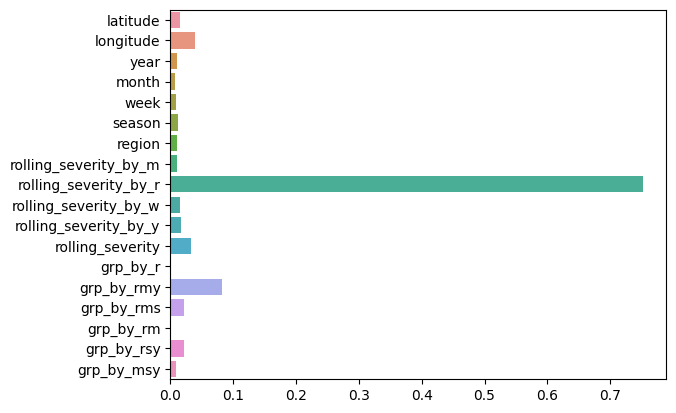

In [409]:
%%time

xgb_reg = XGBRegressor(
    n_estimators=11_000, 
    max_depth=5, 
    learning_rate=0.005, 
    tree_method='gpu_hist',
    gpu_id=0, 
    n_jobs=-1, 
    random_state=42,
    )

te_preds, tr_preds, *_ = cv_it(model=xgb_reg, X_train=X_train, y_train=y_train, X_test=X_val, y_test=y_val, splits=10, cv_predict=True)

In [410]:
data.severity.value_counts(normalize=True)

1.0    0.439449
4.0    0.207913
2.0    0.189859
3.0    0.159379
5.0    0.003400
Name: severity, dtype: float64

In [421]:
%%time

# comparision with 0.66/0.8579
xgb_reg_v0 = XGBRegressor(n_estimators=2000, max_depth=5, learning_rate=0.02, objective='reg:squarederror', tree_method='gpu_hist', gpu_id=0, n_jobs=-1)
xgb_reg_v0.fit(X_train, y_train)
preds = xgb_reg_v0.predict(X_val)
preds = pd.Series(np.round(preds)).clip(1, 5).values
print("train rmse", rmse(y_train, xgb_reg_v0.predict(X_train)))
print("test rmse:", rmse(y_val, preds))

train rmse 0.49438641166551284
test rmse: 0.5989439710206956
CPU times: total: 5.72 s
Wall time: 6.92 s


Using cols:  ['latitude' 'longitude' 'year' 'month' 'week' 'season' 'region'
 'rolling_severity_by_m' 'rolling_severity_by_r' 'rolling_severity_by_w'
 'rolling_severity_by_y' 'rolling_severity' 'grp_by_r' 'grp_by_rmy'
 'grp_by_rms' 'grp_by_rm' 'grp_by_rsy' 'grp_by_msy']
----------------------------------Fold-0------------------------------------
Training on 15249 samples
Validating on 958 samples
1.0    0.591858
2.0    0.242171
3.0    0.140919
4.0    0.020877
5.0    0.004175
Name: severity, dtype: float64
Train RMSE:  0.5367960903599671
Val RMSE: 0.6621279039348079
TEST RMSE:  0.5930429012868341
----------------------------------Fold-1------------------------------------
Training on 15249 samples
Validating on 958 samples
1.0    0.582463
2.0    0.249478
3.0    0.132568
4.0    0.033403
5.0    0.002088
Name: severity, dtype: float64
Train RMSE:  0.5391122418495856
Val RMSE: 0.7078445036419488
TEST RMSE:  0.5930429012868341
----------------------------------Fold-2-------------------------

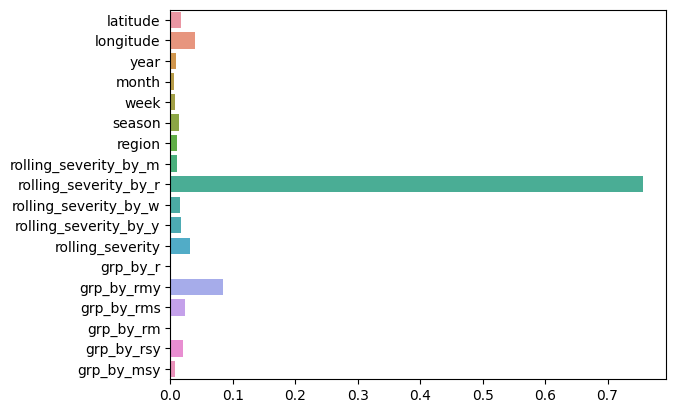

In [422]:
_ = cv_it(model=xgb_reg_v0, X_train=X_train, y_train=y_train, X_test=X_val, y_test=y_val, splits=10, cv_predict=False)

# Test predictions

In [412]:
X_train.columns

Index(['latitude', 'longitude', 'year', 'month', 'week', 'season', 'region',
       'rolling_severity_by_m', 'rolling_severity_by_r',
       'rolling_severity_by_w', 'rolling_severity_by_y', 'rolling_severity',
       'grp_by_r', 'grp_by_rmy', 'grp_by_rms', 'grp_by_rm', 'grp_by_rsy',
       'grp_by_msy'],
      dtype='object')

In [413]:

# all_train = all_data[all_data.split == 'train']
# all_test = all_data[all_data.split == 'test']

all_train = data[data.split == 'train']
all_test = data[data.split == 'test']

all_train.region = all_train.region.map(reg_map)
all_test.region = all_test.region.map(reg_map)

all_train.week = all_train.week.astype('int')
all_test.week = all_test.week.astype('int')

drop_cols = ['uid', 'split', 'date', 'severity', 'density']
all_train.shape, all_test.shape

((17060, 23), (6510, 23))

In [414]:
X = all_train.drop(drop_cols, axis=1)
y = all_train['severity']
X_test = all_test.drop(drop_cols, axis=1)

X.shape, y.shape, X_test.shape

((17060, 18), (17060,), (6510, 18))

In [415]:
assert X_test.columns.equals(X.columns)

In [416]:
print('Training on:', X.columns.values)

xgb_reg = XGBRegressor(
    n_estimators=11_000, 
    max_depth=5, 
    learning_rate=0.005, 
    tree_method='gpu_hist',
    gpu_id=0, 
    n_jobs=-1, 
    random_state=42,
    )

xgb_reg.fit(X, y)
test_preds = xgb_reg.predict(X_test)
test_preds = pd.Series(np.round(test_preds)).clip(1, 5).values
print("train rmse", rmse(y, xgb_reg.predict(X)))

Training on: ['latitude' 'longitude' 'year' 'month' 'week' 'season' 'region'
 'rolling_severity_by_m' 'rolling_severity_by_r' 'rolling_severity_by_w'
 'rolling_severity_by_y' 'rolling_severity' 'grp_by_r' 'grp_by_rmy'
 'grp_by_rms' 'grp_by_rm' 'grp_by_rsy' 'grp_by_msy']
train rmse 0.4766092098428704


In [417]:
X.shape, y.shape

((17060, 18), (17060,))

In [418]:
y.value_counts(normalize=True)

1.0    0.439449
4.0    0.207913
2.0    0.189859
3.0    0.159379
5.0    0.003400
Name: severity, dtype: float64

In [419]:
pd.Series(test_preds).value_counts(normalize=True)

2.0    0.306605
4.0    0.275422
1.0    0.213364
3.0    0.197389
5.0    0.007220
dtype: float64

# Submission

In [420]:
sub_format.severity = test_preds.astype(int)
display(sub_format.sample(5))
sub_format.to_csv('../submissions/to submit/xgbreg_rolling3grpby.csv', index=False)

,uid,region,severity
1777,hecv,west,4
564,chgk,northeast,1
1103,ekta,west,4
3660,opxd,midwest,2
1738,gzeq,south,3
